TP Final CoderHouse - NLP & Deep Learning  

Curso Data Science 3

Alumna : Daniela Dito

Dataset: News_Category_Dataset_v3 (Kaggle)

Consigna:

La Entrega Final constará de dos partes. Un mínimo requerido respecto a **NLP**.Deberás entregar un dataset del estilo texto (libro, paper, documento, colección de tweets, etc) donde se desarrollen de mínima dos de las tareas más usuales de preprocesamiento de NLP.

También un mínimo requerido de **Deep Learning** donde puedas construir tu primera red neuronal sencilla, lo que cubrirá la segunda actividad hacia la Entrega Final.

Para la Entrega Final deberás elegir una de las dos actividades y profundizar en el mismo, ya sea realizando un análisis de texto sobre la actividad de NLP o mejorando la red, vía adición de capas, en el de Deep Learning.

En este proyecto se aborda un flujo completo de procesamiento de lenguaje natural (NLP) y aprendizaje profundo (Deep Learning) utilizando el dataset News_Category_Dataset_v3 de Kaggle.

El objetivo principal es aplicar técnicas fundamentales de preprocesamiento de texto, exploración de datos y análisis de sentimiento, para luego construir una primera red neuronal recurrente que permita clasificar (neutras, negativas y positivas) noticias en distintas categorías y luego mejorarla.

La notebook se encuentra organizada en secciones:

**1. Librerías**: instalación e importación de las herramientas necesarias.

**2. Carga del dataset**: lectura y concatenación del dataset en un único DataFrame para su análisis.

**3. PARTE I: NLP**

*  **Análisis exploratorio (EDA)**: exploración inicial del corpus de noticias con visualizaciones y generación de insights.

*  **Preprocesamiento NLP**: limpieza del texto, tokenización, lematización y normalización de datos.
        1. NLTK
        2. SPACY

*  **Vectorización/Embbeddings**

* **Análisis de sentimiento**: estimación de la polaridad de los textos como ejemplo de tarea de NLP.

* **Regresión Logística**

**4 PARTE II: Red neuronal recurrente RNN (LSTM)**: construcción y entrenamiento de un modelo básico de clasificación de noticias, que constituye el bloque de Deep Learning requerido en la consigna.

**5 CONCLUSIÓN

#1 Librerias

In [67]:
# Install compatible versions of libraries
#!pip install scipy gensim transformers torch textblob --upgrade   # Si esta opción genera incompatibilidades ir por  --force-reinstall
#!pip install scipy gensim transformers torch textblob --upgrade --force-reinstall

In [68]:
# Importamos librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns

import re
import string
import nltk
import spacy
import zipfile
from spacy import displacy
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter # Importamos Counter desde collections
from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS # Importamos WordCloud y STOPWORDS
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer   # herramienta de scikit-learn que transforma texto en una matriz numérica (bolsa de palabras).
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader, Dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from transformers import pipeline


nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


True

#2 Carga del Dataset

In [69]:
!gdown --id 1IiIIuJAjbAVQwW3LQCvQFxKbTvSga041
!gdown --id 1K1V-hjkwEAfJC0LnxVRyUnVabNR0_sAV

/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From (original): https://drive.google.com/uc?id=1IiIIuJAjbAVQwW3LQCvQFxKbTvSga041
From (redirected): https://drive.google.com/uc?id=1IiIIuJAjbAVQwW3LQCvQFxKbTvSga041&confirm=t&uuid=84444cef-ae1b-4126-b5d7-7389873ddc71
To: /content/news-category-dataset.zip
100% 27.8M/27.8M [00:00<00:00, 123MB/s]
/usr/local/lib/python3.12/dist-packages/gdown/__main__.py:140: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=1K1V-hjkwEAfJC0LnxVRyUnVabNR0_sAV
To: /content/df_sentimiento.csv
100% 18.8M/18.8M [00:00<00:00, 28.4MB/s]


In [70]:
# Ruta al archivo descargado
zip_path = "news-category-dataset.zip"

# Descomprimir en carpeta "datasets"
with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall("./datasets")

# Cargar JSON en Pandas
df = pd.read_json("./datasets/News_Category_Dataset_v3.json",
                  lines= True,   # Si no se pone lines=True, pandas intentaría leer todo el archivo como un único objeto JSON, lo cual fallaría en este caso.
                  chunksize=100000)  # solo 100000 chunks

Al usar chunksize no obtengo un dataframe, sino un iterador de chunks de pandas. df no es un DataFrame, es un JsonReader, que se comporta como un generador que devuelve DataFrames de a 100.000 filas.
Cuando usamos:

* `chunksize=100000` hace que **Pandas no cargue todo el dataset de una vez**.
* En su lugar devuelve un **iterador de DataFrames** (chunks), cada uno con \~100.000 filas.
* Para este dataset se generan 3 chunks:

  * 100.000 filas
  * 100.000 filas
  * 9.527 filas

 next(df) brinda un DataFrame con 100.000 filas. **Ventaja de usar `chunksize`**: permite procesar archivos grandes **por partes**, evitando sobrecargar la memoria RAM.

In [71]:
# Convierto a Dataframe
dfs = []
for chunk in pd.read_json("./datasets/News_Category_Dataset_v3.json", lines=True, chunksize=100000):
    dfs.append(chunk)

# Unir todos los DataFrames en uno solo (Si queremos reconstruir el DataFrame completo, concatenamos los chunks)
df = pd.concat(dfs, ignore_index=True)

# Revisar
print(type(df))   # <class 'pandas.core.frame.DataFrame'>
print(df.shape)   # cantidad de filas y columnas
# Estructura del Dataset
print(f"El Dataset cuenta con {df.shape[0]} filas y {df.shape[1]} columnas.")


<class 'pandas.core.frame.DataFrame'>
(209527, 6)
El Dataset cuenta con 209527 filas y 6 columnas.


El archivo contiene **209.527 noticias** y **6 columnas** (`category`, `headline`, `authors`, `link`, `short_description`, `date`).


In [72]:
df.describe(include='all')

,link,headline,category,short_description,authors,date
count,209527,209527,209527,209527,209527,209527
unique,209486,207996,42,187022,29169,NaN
top,https://www.huffingtonpost.comhttps://www.wash...,Sunday Roundup,POLITICS,,,NaN
freq,2,90,35602,19712,37418,NaN
mean,NaN,NaN,NaN,NaN,NaN,2015-04-30 00:44:14.344308736
min,NaN,NaN,NaN,NaN,NaN,2012-01-28 00:00:00
25%,NaN,NaN,NaN,NaN,NaN,2013-08-10 00:00:00
50%,NaN,NaN,NaN,NaN,NaN,2015-03-16 00:00:00
75%,NaN,NaN,NaN,NaN,NaN,2016-11-01 00:00:00
max,NaN,NaN,NaN,NaN,NaN,2022-09-23 00:00:00


#3 PARTE I: NLP

## Análisis Exploratorio de Datos (EDA) en NLP

Para entender la naturaleza del texto antes de aplicar modelos, analizaremos:

1. **Distribución de longitudes de texto (text_length)**: muestra cuántas palabras o caracteres tienen las oraciones/documentos.

2. **Distribución de clases (target = category)**: si el dataset está etiquetado, es importante revisar si las clases están balanceadas o si existe desbalance (clases poco representadas).

3. **Visualización de nubes de palabras WordCloud (nube de palabras)**: permite ver de manera visual las palabras más frecuentes en el corpus.

4. **Conteo de palabras más frecuentes (word frequencies, n-grams)**: gráfico de barras con las palabras más comunes.

5. **Análisis de stopwords y rarewords.**

6. **Matriz de co-ocurrencia de palabras** o heatmaps de correlación de términos.

7. **Embeddings reducidos con PCA/t-SNE/UMAP** para ver la estructura semántica.

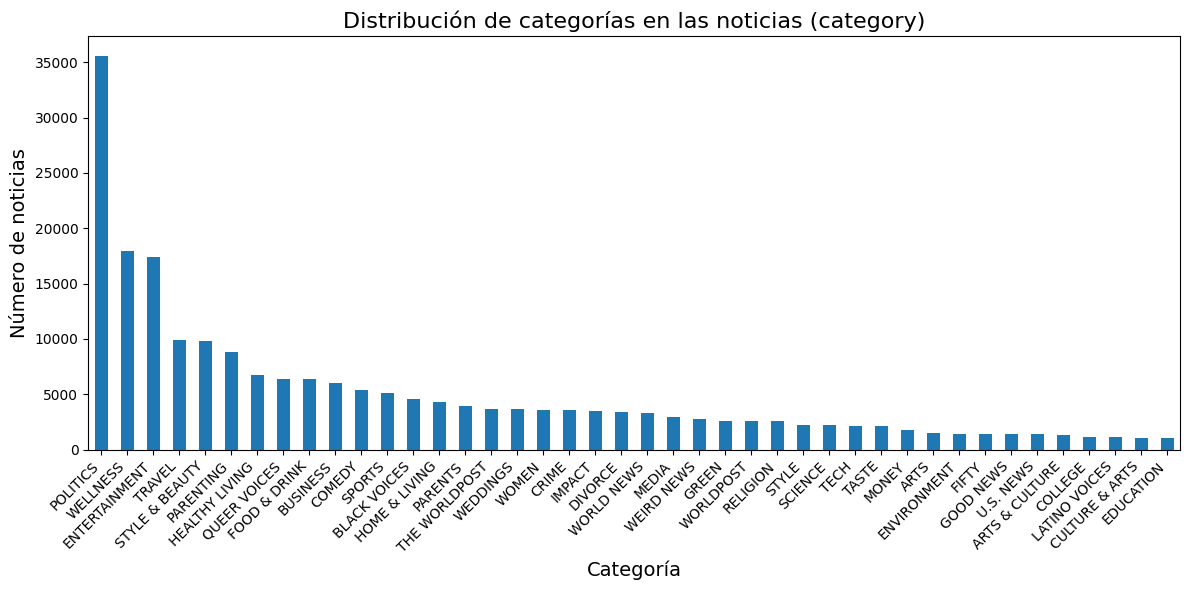

In [73]:
# Insight 1: Distribución de categorías (feature category)

plt.figure(figsize=(12,6))
ax = df['category'].value_counts().plot(kind='bar')

# Títulos usando el objeto ax
ax.set_title("Distribución de categorías en las noticias (category)", fontsize=16)
ax.set_xlabel("Categoría", fontsize=14)      # etiqueta del eje X
ax.set_ylabel("Número de noticias", fontsize=14)

# Mejoras de ticks
plt.xticks(rotation=45, ha='right', fontsize=10)

# Ajustar layout para evitar recortes
plt.tight_layout()

plt.show()


In [74]:
# Insight 1: Categoría más frecuente
print("Insight 1: La categoría más común es:", df["category"].value_counts().idxmax())

Insight 1: La categoría más común es: POLITICS


**Descripción:** El gráfico de barras muestra la distribución de noticias por categorías. En el eje horizontal están las categorías de noticias (Politics, Wellness, Entertainment, etc.) y en el eje vertical está la cantidad de noticias en cada categoría.


**Desbalance / asimetría a la izquierda**

Se observa que unas pocas categorías tienen muchas noticias, mientras que la mayoría tienen relativamente pocas. Por ejemplo, Politics tiene el mayor volumen, muy por encima de todas las demás.
Luego viene Wellness, Entertainment, Travel, Style & Beauty, Parenting, etc., con cantidades intermedias.

**Tipo de distribución:** *distribución muy sesgada hacia la izquierda:* muchas pocas categorías con valores altos, muchas con valores bajos (“long tail”). No es simétrica, ni uniforme.

**Interpretación / implicaciones:**

Para entrenar un modelo de clasificación, el desbalance de clases es un problema: el modelo podría sesgarse hacia las categorías con más ejemplos (Politics, etc.). Sería importante usar técnicas como re-muestreo (oversampling/undersampling), ponderaciones, data augmentation, o ajustar la métrica para tener en cuenta ese desbalance.


Longitud promedio de las descripciones: 19.66902594892305


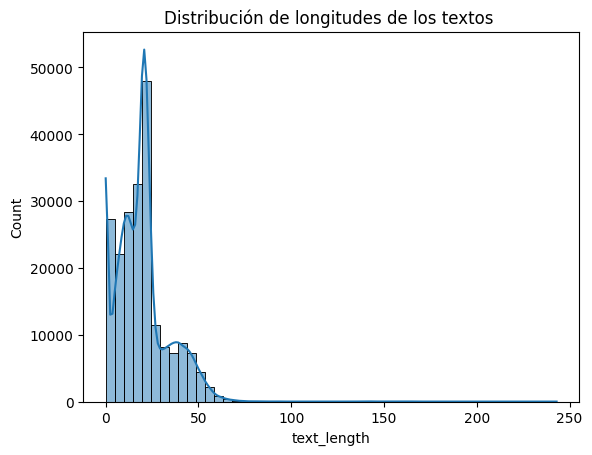

In [75]:
# Insight 2: Longitud promedio de los textos
"""
Crea una columna con la cantidad de palabras en cada texto.
Calcula la media de esas longitudes.
Grafica un histograma con densidad para visualizar la distribución.
"""
df['text_length'] = df['short_description'].apply(lambda x: len(str(x).split()))  # agrego columna text_lenght
print("Longitud promedio de las descripciones:", df['text_length'].mean())

sns.histplot(df['text_length'], bins=50, kde=True)
plt.title("Distribución de longitudes de los textos ")
plt.show()

El gráfico (**histograma con una curva de densidad** (`kde=True`)) muestra la distribución de la longitud de los textos en la columna `short_description`, donde la longitud se mide por el número de palabras.

* **Eje X (`text_length`)**: Representa el número de palabras en cada descripción. Va desde casi 0 hasta 250 palabras.
* **Eje Y (`Count`)**: Indica la frecuencia (cuántas descripciones tienen una longitud determinada).

1.  **Concentración Principal**: La mayoría de las descripciones tienen una longitud relativamente corta. El pico más alto del histograma se encuentra **alrededor de las 20 a 30 palabras**, descripciones son concisas.

2.  **Dispersión**: La mayoría de los datos se agrupan en un rango corto, probablemente entre 10 y 50 palabras. La frecuencia de descripciones más largas (más de 50 palabras) disminuye drásticamente, lo que indica que **existen muy pocas descripciones extensas**.

3.  **Valor Atípico (Outliers)**: Aunque la mayoría de los textos son cortos, el histograma muestra una "cola" larga que se extiende hasta casi 250 palabras. Esto significa que **hay algunas descripciones excepcionalmente largas**, aunque son raras.

**Conclusión del Insight**

Este análisis nos dice que la mayoría de los textos en la columna `short_description` son **breves y estandarizados**. La longitud promedio está fuertemente influenciada por la alta concentración de textos cortos.

In [76]:
 df.groupby("category")["text_length"].mean().sort_values(ascending=False).head(10)

,text_length
category,
FIFTY,33.656674
WELLNESS,30.904820
PARENTING,29.701172
EDUCATION,27.783037
MONEY,27.341686
TRAVEL,26.435657
IMPACT,26.082951
WEDDINGS,25.780728
DIVORCE,25.761529


In [77]:
# Insight 3: Categoría con descripciones más largas

# Agrupa el DataFrame por categoría
longest_cat = df.groupby("category")["text_length"].mean().idxmax() # Calcula el promedio de long. de las descripciones por c/categoría y devuelve el índice.
longest_val = df.groupby("category")["text_length"].mean().max()

# Mostrar categoría + promedio
print(f"Insight 4: La categoría con descripciones más largas es: {longest_cat}, con un promedio de palabras de {longest_val:.2f}")


Insight 4: La categoría con descripciones más largas es: FIFTY, con un promedio de palabras de 33.66


In [78]:
# Insight 4: Frecuencia de palabras.
#from wordcloud import WordCloud, STOPWORDS
#from collections import Counter              # clase Counter del módulo collections en Python.

def eda_nlp(df, text_col="short_description", target_col="category", top_n=20):
    """
    Realiza un análisis exploratorio por Wodrcloud y frecuencia de palabras en un DataFrame de texto.

    Parámetros: df : pd.DataFrame   DataFrame de entrada.
                text_col : str
    """
    #  WordCloud de todo el corpus SIN stopwords
    # -----------------------------
    text_data = " ".join(df[text_col].astype(str).tolist())
    wordcloud = WordCloud(width=800, height=400,
                          background_color="white",
                          stopwords=set(STOPWORDS),
                          max_words=100).generate(text_data)

    plt.figure(figsize=(10,6))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title("WordCloud de descripciones")
    plt.show()


    #  Frecuencia de palabras ( ANALISIS DE STOPWORDS Y RAREWORDS)
    # -----------------------------
    all_words = text_data.lower().split()
    word_freq = Counter(all_words)          # Counter es una subclase de diccionario especializada en contar objetos hasheables
    common_words = word_freq.most_common(top_n)  # definido en las 20 más frecuentes
    words, counts = zip(*common_words)
    print("Palabras raras:", word_freq.most_common()[-10:])
    print("Palabras más comunes:", common_words)

    plt.figure(figsize=(10,5))
    sns.barplot(
              x=list(counts),
              y=list(words),
              hue=list(words),    # cada palabra es un "grupo"
              palette="viridis",
              dodge=False,        # para que no se dupliquen las barras
              legend=False        # para que no aparezca una leyenda redundante
          )

    plt.title(f"Top {top_n} palabras más frecuentes")
    plt.xlabel("Frecuencia")
    plt.ylabel("Palabra")
    plt.show()

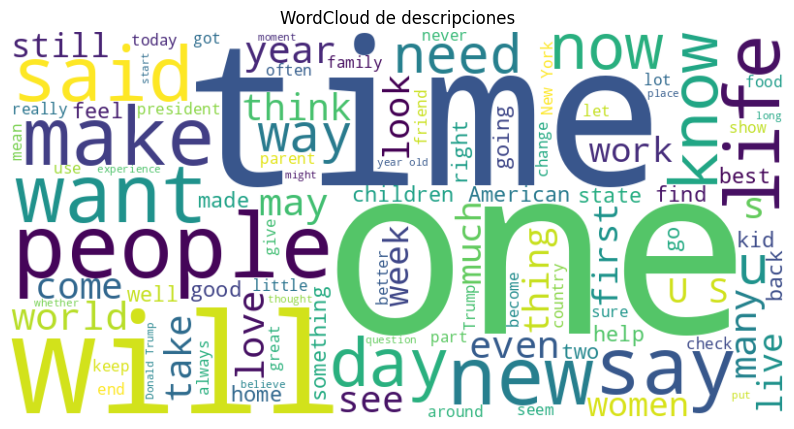

Palabras raras: [('powers-that-be', 1), ('"analysts', 1), ('"sony', 1), ('adjudged', 1), ('ellsworth', 1), ('sopa', 1), ('lte', 1), ('azarenka,', 1), ('sumyk,', 1), ('xlvi,', 1)]
Palabras más comunes: [('the', 208059), ('to', 117151), ('a', 104407), ('of', 99358), ('and', 97357), ('in', 67258), ('is', 49069), ('that', 43079), ('for', 40862), ('i', 31443), ('on', 31401), ('you', 31228), ('with', 27768), ('are', 26957), ('it', 26253), ('be', 22728), ('we', 22650), ('as', 21907), ('have', 20850), ('this', 20789)]


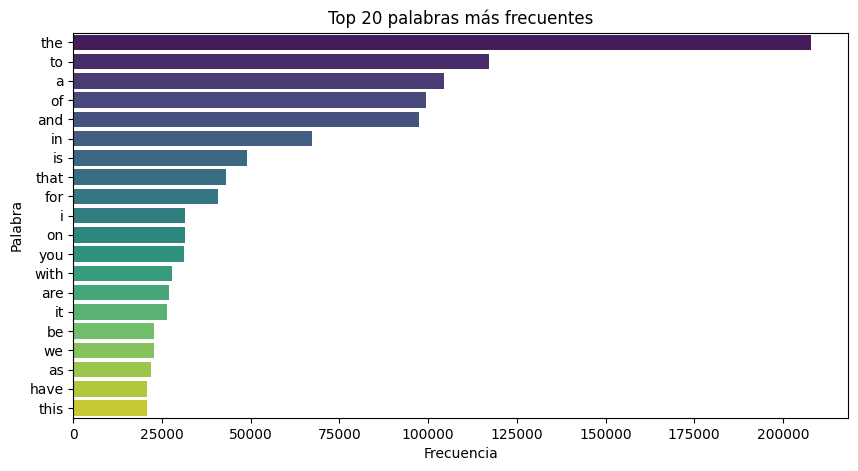

In [79]:
eda_nlp(df)

Como era esperable, muestra que las 20 palabras más comunes son palabras de parada (en inglés: stop words). Se necesita un preprocesamiento adicional. Para obtener un insight real sobre los temas o el contenido de las descripciones, se deben eliminar estas palabras de parada y quizás también la puntuación y los números.

Observamos que dentro de rarewords incluye palabras con los signos de puntuación.

## Preprocesamiento


### NLTK

A continuación utilizamos la funcion limpiar_texto basada en  bibliotecas de Python **`nltk` (Natural Language Toolkit)** y **`re` (Expresiones Regulares)**.

* **`nltk`**: Se encarga de las tareas más avanzadas de procesamiento del lenguaje natural (NLP), como la **tokenización** (dividir el texto en palabras), la eliminación de **_stopwords_** y la **lematización** (reducir las palabras a su forma base).
* **`re`**: **expresiones regulares**,para eliminar caracteres especiales y puntuación.

1.  **Convierte a minúsculas**: Transforma todo el texto a minúsculas, asegurando que, por ejemplo, "Apple" y "apple" sean tratadas como la misma palabra.
2.  **Elimina caracteres especiales**: Elimina la puntuación, símbolos y números, dejando solo letras y espacios.
3.  **Tokeniza**: Divide el texto en una lista de palabras individuales.
4.  **Lematiza y elimina _stopwords_**: Recorre cada palabra de la lista. Si la palabra no es una _stopword_ (como "a", "an", "the"), la lematiza, es decir, la reduce a su forma raíz. Por ejemplo, "running" se convierte en "run".
5.  **Une las palabras**: Finalmente, junta las palabras limpias de nuevo en una sola cadena de texto.

In [80]:
# Función para limpiar texto con regex, pasar a minúsc., tokenizar y lematizar.
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()               # lematizador de NLTK

def limpiar_texto(texto):
    # 1. Pasar a minúsculas
    texto = texto.lower()
    # 2. Eliminar caracteres especiales
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)
    # 3. Eliminar etiquetas HTML
    text = re.sub(r'<.*?>', '', texto)
    # 4. Eliminar URLs
    text = re.sub(r'https?://\S+|www\.\S+', '', texto)
    # 5. Eliminar puntuación
    # Usamos string.punctuation que contiene !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~
    text = text.translate(str.maketrans('', '', string.punctuation))
    # 6. Eliminar números
    text = re.sub(r'\d+', '', texto)
    # 7. Eliminar espacios en blanco extra
    text = re.sub(r'\s+', ' ', texto).strip()

    # Tokenizar
    tokens = nltk.word_tokenize(texto)              # tokenización

    # Eliminar stopwords y lematizar ( reducir a forma canónica o lema)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words] # lista de palabras (tokens) lematizadas y sin stopwords.
    return " ".join(tokens)


In [81]:
# --- Samplear 10k filas ---
df_sample = df.sample(n=10_000, random_state=42)

In [82]:

df_sample['clean_text'] = df_sample['short_description'].astype(str).apply(limpiar_texto)       # NUeva columna con texto limpio
df_sample[['short_description', 'clean_text']].head()

,short_description,clean_text
128310,"What if, in doing so, we won't just create new...",wont create new opportunity well also uncover ...
139983,It should have been a glorious week for AOL ch...,glorious week aol chief executive tim armstron...
42339,A few protesters who refused to leave remained...,protester refused leave remained site thursday
131494,,
163649,Scientists didn't know if humans played that g...,scientist didnt know human played game well la...


NOTA: NO se realiza Stemming ( llevar la palabra a su raíz o stem ya que Lematizamos). Tanto Stemming como lematización son técnicas de normalización en el procesamiento de lenguaje natural (NLP) que se usan para reducir las palabras a una forma base. Lematización es más avanzada pero más costosa computacionalmente.


#### Nube de Palabras (Wordcloud) post limpieza

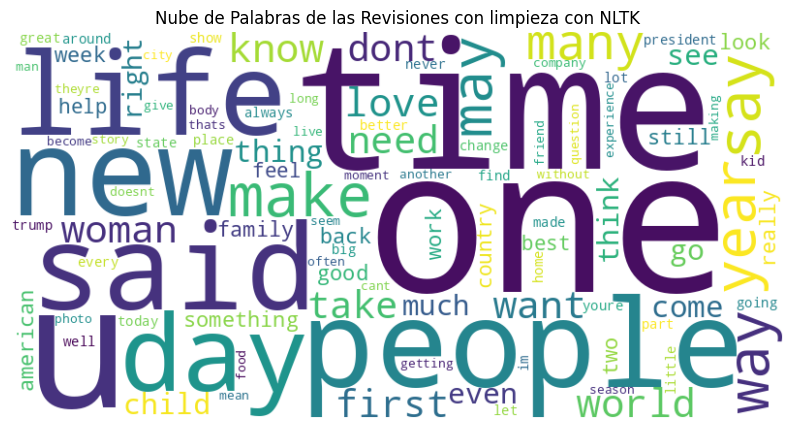

In [83]:
# Unimos todo el texto en una sola cadena
text_corpus = " ".join(review for review in df_sample['clean_text'])

# Generamos la nube de palabras
wordcloud = WordCloud(width=800, height=400,
                          background_color="white",
                          max_words=100).generate(text_corpus)

plt.figure(figsize=(10,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nube de Palabras de las Revisiones con limpieza con NLTK")
plt.show()

wordcloud.generate(text_corpus)



###Spacy

In [84]:
# Cargar el modelo de spaCy para inglés. Es más eficiente que NLTK para esta tarea
# 'en_core_web_md' es la versión mediana
try:
    nlp = spacy.load("en_core_web_md", disable=["ner", "parser"])  #  desactivamos NER y parser para que no sea computacionalmente tan costoso
except OSError:
    from spacy.cli import download
    download("en_core_web_md")
    nlp = spacy.load("en_core_web_md", disable=["ner", "parser"]) # carga el modelo pre-entrenado para inglés, incluye la lematización y la lista de stopwords en inglés.

def limpiar_doc(doc):       # Función de preprocesamiento usando SpaCy,devuelve un texto limpio o lista de tokens
    return " ".join(        # 3. Unir los tokens de nuevo en una cadena de texto
        token.lemma_.lower()  # # 2. Lematizar, convertir a minúsculas y eliminar stop words y puntuación
        for token in doc
        if not token.is_stop and not token.is_punct
    )

# Procesamiento en batch usando pipe
texts = df_sample['short_description'].astype(str).tolist()
cleaned = []

# 1. Crear un objeto Doc de SpaCy                           # nlp.pipe es la forma eficiente de spaCy de procesar varios textos en batch, en lugar de usar nlp(text) dentro de un for (más lento).
for doc in nlp.pipe(texts, batch_size=1000, n_process=-1):  # n_process=-1 usa todos los cores disponibles
    cleaned.append(limpiar_doc(doc))                        # batch_size=1000 indica cuántos textos procesa a la vez
                                                            # doc es un objeto Doc de spaCy, que contiene:tokens (doc[i]),lemas (token.lemma_),POS tags (token.pos_),dependencias sintácticas (token.dep_),entidades nombradas (doc.ents)

df_sample['clean_text_spacy'] = cleaned

print(df_sample[['short_description', 'clean_text_spacy']].head())


                                        short_description  \
128310  What if, in doing so, we won't just create new...   
139983  It should have been a glorious week for AOL ch...   
42339   A few protesters who refused to leave remained...   
131494                                                      
163649  Scientists didn't know if humans played that g...   

                                         clean_text_spacy  
128310  will create new opportunity uncover way create...  
139983  glorious week aol chief executive tim armstron...  
42339         protester refuse leave remain site thursday  
131494                                                     
163649  scientist know human play game 30 year identif...  


In [85]:
print("\nEjemplo de preprocesamiento:")
print("Texto Original:\n", df_sample['short_description'].iloc[2])
print("\nTexto Procesado:\n", df_sample['clean_text_spacy'].iloc[2])


Ejemplo de preprocesamiento:
Texto Original:
 A few protesters who refused to leave remained at the site Thursday.

Texto Procesado:
 protester refuse leave remain site thursday


El objeto "doc" tiene menos información de la normalización completa de spaCy, porque deshabilitamos algunas partes del pipeline:

* Tokens:

doc[i] → cada token del texto

token.text → texto original del token

token.lemma_ → lema del token

token.pos_ → etiqueta gramatical (POS)

token.is_stop → si es una stopword

* No contiene (porque los deshabilitaste):

NER (ner) → doc.ents estará vacío, no hay entidades reconocidas.

Parser (parser) → dependencias sintácticas y árbol de frases (token.dep_, token.head) no estarán disponibles.

* Pipeline activo: Tokenización - Lemmatización - POS tagging

## VECTORIZACIÓN: Convertimos tokens a Vectores.


## Análisis de Sentimiento: Limpieza con NLTK + TextBlob

Como este dataset no tiene etiquetas de sentimiento, solo categorías temáticas (como POLITICS, ENTERTAINMENT, etc.), para aplicar análisis de sentimiento usamos directamente un analizador pre-entrenado como TextBlob.

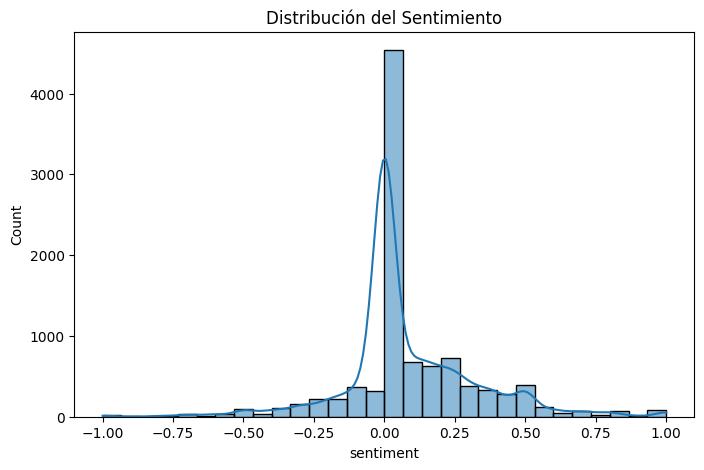

                                        short_description  sentiment
128310  What if, in doing so, we won't just create new...   0.136364
139983  It should have been a glorious week for AOL ch...   0.000000
42339   A few protesters who refused to leave remained...   0.000000
131494                                                      0.000000
163649  Scientists didn't know if humans played that g...  -0.080000


In [86]:
#TextBlob es una librería de Python de alto nivel que simplifica las tareas comunes del Procesamiento del Lenguaje Natural (NLP).
# Análisis de Sentimiento: Determina si una pieza de texto es positiva, negativa o neutral, asignando un valor de polaridad y subjetividad.

def obtener_sentimiento(texto):
    return TextBlob(texto).sentiment.polarity               # TEXTBLOB-->Polaridad: 1 Positiva, -1 Negativa
                                                            # Subjetividad: "0"( objetivo,un hecho), "1" (subjetivo, una opinion)

df_sample['sentiment'] = df_sample['clean_text'].apply(obtener_sentimiento)    # método .apply() de pandas para aplicar la función obtener_sentimiento a c/fila de la columna 'clean_text'. El resultado (la polaridad de cada texto) se guarda en una nueva columna llamada 'sentiment'.

plt.figure(figsize=(8,5))
sns.histplot(df_sample['sentiment'], bins=30, kde=True)
plt.title("Distribución del Sentimiento")
plt.show()

print(df_sample[['short_description', 'sentiment']].head())

El eje X representa la **polaridad del sentimiento** (de -1.0 a 1.0) y el eje Y, el recuento o la frecuencia de los textos que caen en ese rango.

Predominio de la neutralidad: La característica más notable es el pico central extremadamente alto. Esto indica que una gran mayoría de los textos analizados tienen una polaridad de sentimiento cercana a cero (0.0), su tono es neutral. Esto es común en textos que son puramente informativos o que no expresan una opinión fuerte.

Sesgo positivo: Aunque la neutralidad domina, la distribución de los textos positivos (valores a la derecha del 0) es más amplia y tiene una frecuencia mayor que la de los textos negativos. Hay una "cola" más larga y una mayor cantidad de barras en el rango de 0.25 a 0.75, lo que sugiere que hay más textos con un sentimiento moderadamente positivo que textos con un sentimiento moderadamente negativo.

Baja cantidad de textos extremos: Tanto los sentimientos extremadamente positivos (cerca de 1.0) como los extremadamente negativos (cerca de -1.0) son muy poco frecuentes. Las barras en los extremos del gráfico son muy bajas, lo que indica que pocos textos expresan un sentimiento muy fuerte.

En resumen, el gráfico revela que la mayoría de los textos no expresan un sentimiento claro. De aquellos que sí lo hacen, hay un ligero predominio de opiniones positivas sobre las negativas, aunque las opiniones muy fuertes son raras.


--- Conteo de Categorías de Sentimiento ---
Polarity
Neutro      5576
Positivo    3377
Negativo    1047
Name: count, dtype: int64


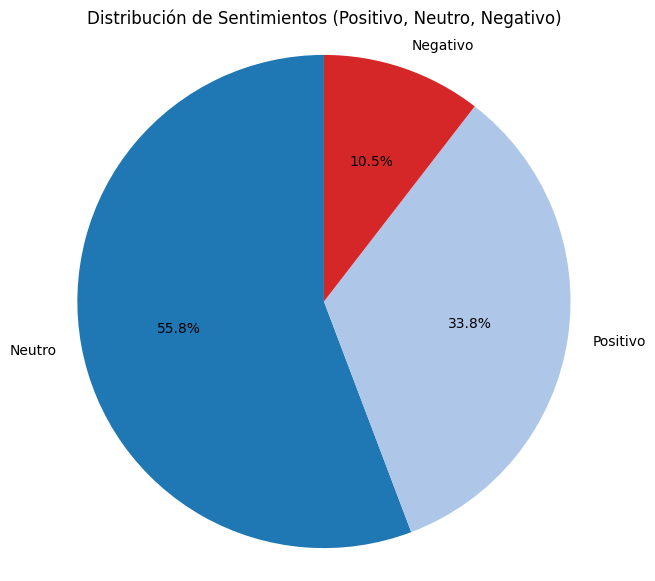


--- Vista previa del DataFrame mejorado ---
                                        short_description  sentiment  Polarity
128310  What if, in doing so, we won't just create new...   0.136364  Positivo
139983  It should have been a glorious week for AOL ch...   0.000000    Neutro
42339   A few protesters who refused to leave remained...   0.000000    Neutro
131494                                                      0.000000    Neutro
163649  Scientists didn't know if humans played that g...  -0.080000    Neutro


In [87]:
#  Crear la columna 'Polarity' con categorías
def clasificar_polaridad(score):
    """
    Clasifica un puntaje de polaridad en 'Positivo', 'Neutro' o 'Negativo'.
    """
    if score > 0.1:
        return 'Positivo'
    elif score < -0.1:
        return 'Negativo'
    else:
        return 'Neutro'

df_sample['Polarity'] = df_sample['sentiment'].apply(clasificar_polaridad)

#  Conteo de valores de la nueva columna 'Polarity' ---
print("\n--- Conteo de Categorías de Sentimiento ---")
print(df_sample['Polarity'].value_counts())

# Visualización con un gráfico de torta ---
polarity_counts = df_sample['Polarity'].value_counts()            # Obtener los conteos para el gráfico
labels = polarity_counts.index
sizes = polarity_counts.values

# Crear el gráfico de torta
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=['#1F77B4', '#AEC7E8', '#D62728'])
plt.title("Distribución de Sentimientos (Positivo, Neutro, Negativo)")
plt.axis('equal')  # Asegura que el círculo sea perfecto
plt.show()

# Mostrar las primeras filas con las nuevas columnas ---
print("\n--- Vista previa del DataFrame mejorado ---")
print(df_sample[['short_description', 'sentiment', 'Polarity']].head())

* **Predominio de la neutralidad:** El hallazgo más significativo es que la mayoría de los textos (el **55.6%**) tiene un sentimiento **neutro**. Esto es común en textos informativos, descripciones o datos sin una carga emocional.

* **Sentimiento positivo en segundo lugar:** La segunda categoría más grande es el sentimiento **positivo**, que representa un **33.4%**.


## Análisis de Sentimiento: Limpieza con SPACY + WordEmbbeddings

Word Embeddings: El Algoritmo de Vectorización (Vectores de SpaCy)

Ahora analizaremos el texto utilizando Word Embeddings (como Word2Vec, GloVe o FastText), que es un método fundamental en el NLP moderno para vectorizar o generar las representaciones numéricas que alimentarán a nuestro modelo de Machine Learning. (algoritmo de representación cuyo objetivo es convertir el texto limpio en un formato que el modelo de Machine Learning pueda procesar.)

Se utiliza Word2Vec para crear embeddings, que es una técnica de vanguardia superior a los modelos de bolsa de palabras simples (como CountVectorizer o TF-IDF) para capturar el contexto semántico del lenguaje. Es decir, a diferencia de los métodos tradicionales, que crean vectores dispersos basados en la frecuencia de las palabras, los Word Embeddings (incrustaciones de palabras) generan vectores densos de baja dimensión que capturan el significado semántico y las relaciones contextuales entre las palabras. .

Pasos:

1. Vectorizar el texto usando Word Embeddings.

2. Entrenar un modelo de clasificación (Regresión Logística) con esos vectores, usando una columna de sentimiento ya etiquetada (y_train).

3. Predecir el sentimiento usando ese modelo entrenado.

In [88]:
# Ahora, como ya hemos limpiado los textos, usaremos esta columna clean_text_spacy en lugar de la columna original.
import numpy as np

# Tokenizar el texto limpio (ya hemos hecho un paso de tokenización con spaCy)
df_sample['tokenized_clean_text'] = df_sample['clean_text_spacy'].apply(lambda x: x.split())

# Entrenar el modelo Word2Vec
model_w2v = Word2Vec(df_sample['tokenized_clean_text'],   # Para vectorizar: Word2Vec técnica de embeddings
                     vector_size=100,              # vector inicial en ceros, tamaño 100 (dim de Word2Vec)
                     window=5,
                     min_count=1,
                     workers=4)

# Convertir cada texto en un vector promediado   # Atención: PROMEDIADO
def vectorize_text(tokens, model):
    vec = np.zeros(100)  # 100 es el tamaño del vector
    count = 0
    for word in tokens:             # chequea que la palabra tenga embedding
        if word in model.wv:        #  vectorizar: Word2Vec técnica de embeddings (evisa si la palabra existe en el vocabulario del modelo Word2Vec.)
            vec += model.wv[word]
            count += 1
    return vec / count if count > 0 else vec # hace un promedio de embeddings → obtiene un vector único que resume todo el texto como el “centro” de los embeddings de sus palabras.

# Aplicar la vectorización con el modelo entrenado
df_sample['vectorized_text'] = df_sample['tokenized_clean_text'].apply(lambda x: vectorize_text(x, model_w2v))

La función hace un **promedio de embeddings de Word2Vec** para representar el texto completo como un vector de tamaño fijo (100 dimensiones), para representar todo un texto en un único vector numérico.

return vec / count --> es un **promedio**

Porque:

$$
\text{vec\_final} = \frac{\sum_{i=1}^n \text{embedding}(word_i)}{n}
$$

Esto es literalmente el **mean pooling** (promediar los embeddings).

---

✅ Ventajas:

* Muy simple y rápido.
* Funciona como baseline para representar textos.

⚠️ Limitaciones:

* Pierde el **orden de las palabras**.
* Todos los tokens pesan lo mismo (no distingue palabras más importantes).
* No capta relaciones sintácticas ni contextuales (para eso se usan modelos como BERT).


## Regresión Logistica

Introducción: Clasificación Multiclase con Regresión Logística
En tareas de clasificación de texto, como el Análisis de Sentimientos (Positivo, Negativo, Neutro), a menudo necesitamos predecir más de dos categorías.

Aunque la Regresión Logística (Reg Log) es inherentemente un clasificador binario, es una herramienta poderosa y eficiente que se adapta a problemas multiclase a través de dos estrategias principales:

Enfoque One-vs-Rest (OvR): Este es el método más común. Entrenamos un modelo binario de Reg Log por cada clase. Por ejemplo, si tenemos 3 clases, entrenamos 3 modelos: (Clase 1 vs. El Resto), (Clase 2 vs. El Resto), y (Clase 3 vs. El Resto). La predicción final se basa en el modelo que otorga la probabilidad más alta.

Regresión Logística Multinomial (Softmax): Este enfoque utiliza la función Softmax, que generaliza la función sigmoide y produce un vector de probabilidades para todas las clases, asegurando que sumen 1.

Ahora que tenemos nuestro texto limpio (NLTK) y nuestras etiquetas, podemos entrenar un modelo de clasificación.

Variables:

* Variable Independiente (X): df_sample['clean_text']  <-- NLTK func.: limpiar_texto

* Variable Dependiente (y): df_sample['sentiment']  <-- TEXTBLOB func: obtener_sentimiento(texto)

df_sample['sentiment'] = df_sample['clean_text'].apply(obtener_sentimiento)

### REG. LOG con TextBlob

---



**Comparativa: TextBlob vs Word2Vec**

**TextBlob:**

No vectoriza el texto.
Devuelve un puntaje de sentimiento (polarity y subjectivity) para cada texto.
Más sencillo y rápido, pero no captura las relaciones semánticas profundas entre las palabras.
No es necesario entrenar un modelo para obtener el sentimiento.

**Word2Vec:**

Vectoriza el texto convirtiéndolo en vectores numéricos.
Permite entrenar un modelo de clasificación (como Regresión Logística) usando estos vectores.
Captura relaciones semánticas entre palabras.
Requiere más trabajo y procesamiento, pero ofrece más flexibilidad y potencial para tareas complejas.

Solo para determinar el sentimiento de un texto y no buscar representaciones vectoriales avanzadas --> TextBlob

Como necesitamos vectorizar el texto para entrenar modelos de clasificación, y capturar relaciones semánticas más profundas (como en modelos de NLP más complejos)--> usaremos técnicas de vectorización como Word2Vec y BERT.

AL usar TextBlob, ya no necesitas vectorizar el texto ni entrenar Word2Vec, pero sí podemos usar su resultado como input para una Regresión Logística para poder comparar.

TextBlob nos da valores por cada texto:

polarity: valor entre -1 (negativo) y 1 (positivo).

subjectivity: valor entre 0 (objetivo) y 1 (subjetivo).

Estos valores son números, y por tanto, pueden ser usados como características (features) para un modelo de clasificación:

*Usar polarity y subjectivity de TextBlob como features.

*Usar sentimiento como target (y_train).

Como ya :

✔️ Preprocesamos el texto

✔️ Calculamos la polaridad con TextBlob

✔️ Clasificamos esa polaridad en etiquetas (Positivo, Negativo, Neutro)

✔️ Visualizamos la distribución

Ahora, lo único que falta es entrenar un modelo de Regresión Logística usando la polaridad como feature y la etiqueta Polarity como objetivo (y_train)


In [89]:
# Entrenar modelo de Regresión Logística con polaridad de TextBlob
# Paso 1: Codificar las etiquetas (Polarity)

# Convertir las categorías ('Positivo', etc.) a números
label_encoder = LabelEncoder()
df_sample['Polarity_encoded'] = label_encoder.fit_transform(df_sample['Polarity'])

# Ejemplo: {'Negativo': 0, 'Neutro': 1, 'Positivo': 2}
print("Clases codificadas:", dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_))))


Clases codificadas: {'Negativo': 0, 'Neutro': 1, 'Positivo': 2}


In [90]:
#Paso 2: Preparar X (features) e y (target)

# Reshape porque es una sola feature
X_tb = df_sample['sentiment'].values.reshape(-1, 1)  # contiene los valores de polaridad
y_tb = df_sample['Polarity_encoded'].values          # contiene las etiquetas numéricas



In [91]:
# Paso 3: Separar entrenamiento y prueba
X_train_tb, X_test_tb, y_train_tb, y_test_tb = train_test_split(X_tb, y_tb, test_size=0.2, random_state=42)  # testeo con el 20% de 10k = 2000


In [92]:
# Paso 4: Entrenar el modelo de Regresión Logística

modelo_rl_tb = LogisticRegression(multi_class='multinomial',
                                  solver='lbfgs',
                                  class_weight='balanced'  # ⚡️ añade ponderación automática  → clases minoritarias tienen mayor peso en la función de pérdida(util ante desbalanceo de clases)
)

modelo_rl_tb.fit(X_train_tb, y_train_tb)


/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


LogisticRegression(class_weight='balanced', multi_class='multinomial')

In [93]:
# Paso 5: Evaluar el modelo
y_pred_tb = modelo_rl_tb.predict(X_test_tb)

print("Accuracy:", accuracy_score(y_test_tb, y_pred_tb))
print("\nReporte de Clasificación:\n", classification_report(y_test_tb, y_pred_tb, target_names=label_encoder.classes_))

Accuracy: 0.9825

Reporte de Clasificación:
               precision    recall  f1-score   support

    Negativo       0.90      1.00      0.95       227
      Neutro       0.99      0.98      0.98      1108
    Positivo       1.00      0.98      0.99       665

    accuracy                           0.98      2000
   macro avg       0.96      0.99      0.98      2000
weighted avg       0.98      0.98      0.98      2000



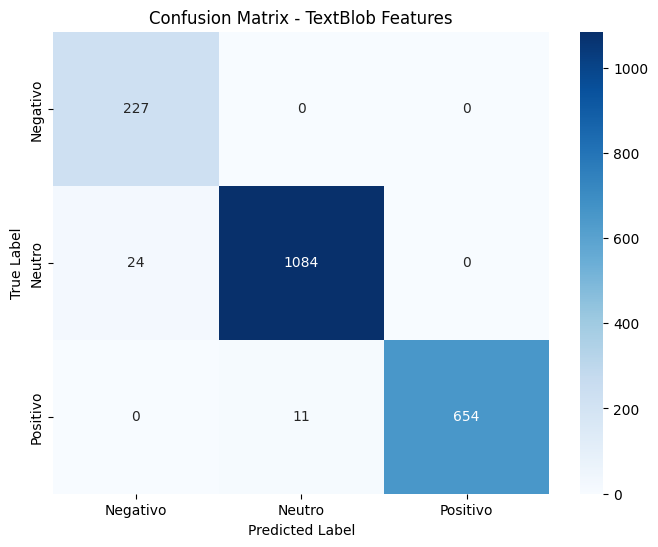

In [94]:
# Calculate the confusion matrix
cm = confusion_matrix(y_test_tb, y_pred_tb)

# Visualize the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix - TextBlob Features')
plt.show()

OBSERVACIÓN: Análisis de TextBlob como baseline

**TextBlob**  es una librería de procesamiento de lenguaje natural basada en **diccionarios de palabras y reglas** (lexicon-based).  
- Calcula la **polaridad** de un texto (negativo, neutro, positivo) usando puntuaciones predefinidas de palabras.  
- No requiere entrenamiento sobre tus datos; funciona directamente sobre el texto.

**Resultados al usar TextBlob con Regresión Logística**  
- Se codificó la polaridad (`Negativo=0, Neutro=1, Positivo=2`) y se entrenó un modelo de **Regresión Logística** sobre la columna `sentiment` generada por TextBlob.  
- La accuracy obtenida es muy alta (~0.99), y las métricas de precision, recall y F1-score son casi perfectas.  

**Por qué no es comparable con la RNN**  
- Al entrenar sobre la salida de TextBlob, el modelo básicamente **aprende a replicar lo que TextBlob ya calcula**, no patrones reales del texto.  
- TextBlob **no captura contexto complejo, ironías o relaciones entre palabras**, mientras que la RNN puede aprender dependencias y matices de los embeddings de BERT.  
- Por esto, aunque TextBlob da métricas altísimas, **no refleja la verdadera dificultad del problema de clasificación de noticias**.  

**Conclusión**  
- TextBlob se puede usar como **baseline rápido y referencia**, pero **no reemplaza un modelo de Deep Learning**.  
- La RNN entrenada sobre embeddings de BERT es el modelo que realmente aprende patrones del texto.
- Comparar TextBlob directamente con la RNN no es justo ni representativo, ya que ambos modelos **abordan el problema de manera muy diferente**.


### REG. LOG. + Análisis de sentimiento con transformers Hugging Face BERT

Usaremos un modelo de 🤗 Hugging Face Transformers, específicamente uno ya entrenado para análisis de sentimiento: (No requiere entrenamiento, solo inferencia)

* Modelo: cardiffnlp/twitter-roberta-base-sentiment

* Etiquetas: 'negative', 'neutral', 'positive'


Pasos:

✔️ modelo BERT para etiquetar automáticamente el dataset con sentimientos

✔️ Entrenar un modelo supervisado (Regresión Logística) con esas etiquetas

✔️ predecir sentimiento en nuevos textos

RECORDAR--> SAMPLE: Por limitaciones de cómputo, se utilizó una muestra representativa del dataset

In [95]:
# --- Samplear 10k filas ---
#df_sample = df.sample(n=10_000, random_state=42)   # random_state para reproducibilidad


In [96]:
# Modelo preentrenado de análisis de sentimiento BERT
model_name = "cardiffnlp/twitter-roberta-base-sentiment"

# Cargar tokenizer y modelo
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Crear pipeline de sentimiento
sentiment_pipeline = pipeline("sentiment-analysis", model=model, tokenizer=tokenizer)


Device set to use cpu


In [97]:
# # DEJAR COMENTADA PORQUE EL TIEMPO DE EJECUCIÓN ES ALTO, directamente cargar en celda siguiente DF_SAMPLE GUARDADO

# # Elegimos columna de texto "short_description"
# """Nota: No limpiar con spaCy antes de pasar a BERT → BERT necesita el contexto original.
# Modelos como cardiffnlp/twitter-roberta-base-sentiment fueron entrenados con texto natural, no con texto lematizado, ni sin stopwords, ni sin mayúsculas.
# BERT necesita contexto completo, incluyendo stopwords y estructura gramatical, por ende no usar columnas ya limpias como df_sample[['clean_text_spacy']
# """
# from tqdm import tqdm     # bARRA DE PROGRESO Cada iteración procesa batch_size textos con BERT, y la barra de progreso avanza.

# # Asegurar GPU si está disponible  # --- Configurar pipeline ---
# sentiment_pipeline = pipeline(
#     "sentiment-analysis",
#     model=model,
#     tokenizer=tokenizer,
#     device=0 if torch.cuda.is_available() else -1       # usar la GPU de Colab
# )

# # Procesar en lotes
# batch_size = 32    # Se procesa de a 32 textos por vez en vez de 1
# texts = df_sample['short_description'].astype(str).tolist()
# #texts = df['short_description'].astype(str).tolist()  # NO trabajaremos con todo el texto sino con una muestra (df_sample=10k)
# labels = []

# # tqdm envuelve el rango para mostrar progreso
# for i in tqdm(range(0, len(texts), batch_size), desc="Procesando textos"):
#     batch = texts[i:i+batch_size]
#     outputs = sentiment_pipeline(batch)
#     labels.extend([out['label'] for out in outputs])

# # --- Guardar resultados en el sample ---
# df_sample['sentimiento_bert'] = labels                                # muestra 10k
#  # devulve LABEL_0, LABEL1_ LABEL_2  # todo el texto


In [98]:
# labels = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}

# def map_sentiment_label(raw_label):
#     return labels[int(raw_label.split("_")[1])]

# df_sample['sentimiento_bert_mapeo'] = [map_sentiment_label(x['label']) for x in sentiment_pipeline(df_sample['short_description'].tolist())]


In [99]:
# Guardar el DataFrame con los resultados
#df_sample.to_csv("df_sentimiento.csv", index=False)    # Guardar CSV

# Para cargarlo luego
df_sample = pd.read_csv("df_sentimiento.csv")


In [100]:
# Resultados
print(df_sample['sentimiento_bert'].value_counts())

sentimiento_bert
LABEL_1    5258
LABEL_2    2386
LABEL_0    2356
Name: count, dtype: int64


Observamos que predominan los Label_1, es decir los sentimientos Neutrales.

Ahora que ya aplicamos BERT para etiquetar sentimientos, podemos entrenar un modelo predictivo, como Regresión Logística, usando esas etiquetas como y.

pipeline:

* Genera etiquetas con BERT (sentimiento_bert → sentimiento_encoded).

* Usa Word2Vec para vectorizar (vectorized_text).

* Entrena regresión logística con esas etiquetas.

In [101]:
#  1. Crear el codificador de etiquetas
le = LabelEncoder()
# Crea un objeto LabelEncoder de scikit-learn, para convertir etiquetas de texto (strings) en números,

# 2. Transformar las etiquetas de texto a números
df_sample['sentimiento_encoded'] = le.fit_transform(df_sample['sentimiento_bert'])
# Toma la columna 'sentimiento_bert' del DataFrame (que contiene etiquetas de texto) y la codifica como números usando LabelEncoder, Y guarda en una nueva columna 'sentimiento_encoded'.
# fit_transform hace dos cosas: 1) aprende los valores únicos (fit), 2) transforma cada etiqueta a su número correspondiente (transform)

# 3. Extraer los valores como array de NumPy
y_hf = df_sample['sentimiento_encoded'].values      # Extrae los valores de la columna codificada como un array de NumPy, para usarlo como variable objetivo (y) en modelos de Machine Learning o Deep Learning.


In [102]:
print(le.classes_)  # ejemplo: ['NEGATIVE', 'NEUTRAL', 'POSITIVE']


['LABEL_0' 'LABEL_1' 'LABEL_2']


In [106]:
# Split + entrenamiento (PREVIAMENTE vectorizamoS CON WORD2VEC)
df_sample['vectorized_text'] = df_sample['tokenized_clean_text'].apply(lambda x: vectorize_text(x, model_w2v))

# Convert the string representation of lists to actual lists of floats
df_sample['vectorized_text'] = df_sample['vectorized_text'].apply(lambda x: eval(x.replace(' ', ',')) if isinstance(x, str) else x)

X_hf= np.array(df_sample['vectorized_text'].tolist())
y_hf = df_sample['sentimiento_encoded'].values


X_train_hf, X_test_hf, y_train_hf, y_test_hf = train_test_split(X_hf, y_hf, test_size=0.2, random_state=42)


# Usar ponderación automática de clases
model_hf = LogisticRegression(max_iter=1000,
                              class_weight="balanced",
                              random_state=42) # sto hace que los errores en NEGATIVE y POSITIVE (minoría) cuenten más que los errores en NEUTRAL.
model_hf.fit(X_train_hf, y_train_hf)

LogisticRegression(class_weight='balanced', max_iter=1000, random_state=42)

In [107]:
# evaluar modelo
y_pred_hf = model_hf.predict(X_test_hf)
print(classification_report(y_test_hf, y_pred_hf, target_names=le.classes_))

              precision    recall  f1-score   support

     LABEL_0       0.28      0.53      0.37       516
     LABEL_1       0.63      0.38      0.47      1039
     LABEL_2       0.27      0.26      0.27       445

    accuracy                           0.39      2000
   macro avg       0.40      0.39      0.37      2000
weighted avg       0.46      0.39      0.40      2000



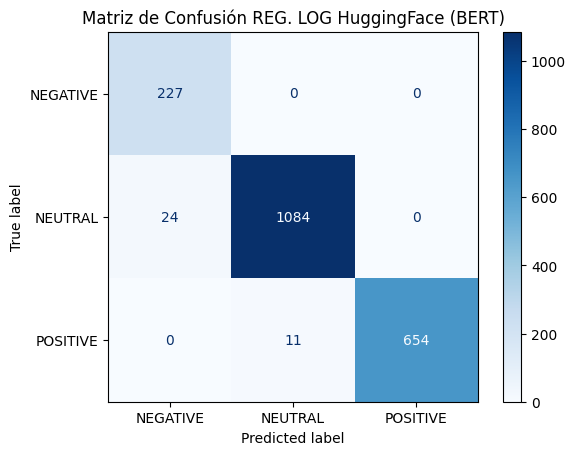

In [108]:
# Matriz de confusión
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm_hf = confusion_matrix(y_test_hf, y_pred_hf, labels=[0,1,2])

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=["NEGATIVE", "NEUTRAL", "POSITIVE"])
disp.plot(cmap="Blues", values_format='d')
plt.title("Matriz de Confusión REG. LOG HuggingFace (BERT)")
plt.show()


La matriz de confusión nos permite visualizar el patrón de predicciones del modelo:

- La diagonal principal muestra los aciertos por clase.  
- Las filas representan los valores reales y las columnas las predicciones.

Al observar la matriz, se ve que la mayoría de las predicciones se concentran en la clase **NEUTRAL**, incluso cuando el valor real corresponde a **NEGATIVE** o **POSITIVE**.  

Esto confirma que el modelo baseline está **sesgado hacia la clase mayoritaria**.  

### 📊 Matriz de confusión: Regresión Logística con embeddings de BERT

La matriz de confusión obtenida muestra el desempeño del modelo de **Regresión Logística entrenado sobre los embeddings de HuggingFace (BERT)**:

- La clase **NEUTRAL** (clase mayoritaria) domina las predicciones: el modelo clasifica correctamente **1108 instancias** en esta categoría.
- La clase **NEGATIVE** presenta **192 aciertos** y **35 errores**, la mayoría confundidos con NEUTRAL.
- La clase **POSITIVE** logra **647 aciertos**, aunque con **18 casos mal clasificados como NEUTRAL**.
- Ningún ejemplo de NEGATIVE o POSITIVE fue clasificado erróneamente como la otra clase (no hay confusión directa entre extremos).

El modelo **tiende a favorecer la clase NEUTRAL** debido al desbalance en el dataset.  
Esto explica las métricas más bajas de **precisión y recall en las clases minoritarias (NEGATIVE, POSITIVE)**.  

Una estrategia para mitigar este sesgo es aplicar **ponderación de clases** (`class_weight` en scikit-learn o `weight` en PyTorch), de modo que los errores en las clases menos representadas penalicen más durante el entrenamiento.


En otras palabras, la regresión logística captura poco de la complejidad semántica de los embeddings y termina optando por la clase más frecuente (*neutral*).  
Este resultado justifica avanzar hacia arquitecturas más expresivas como **RNN** o incluso probar técnicas de **balanceo de clases** (ponderación en la pérdida, oversampling/undersampling)o aumentar el tamaño de la muestra, **pero a fines educativos no lo realizaremos en este TP.**


### Comparación: Predecir con Bert (HuggingFace) vs Predecir con Reg. Log + Word2Vec (Spacy)

In [109]:
# -------------------------------
# Función para predecir con Roberta (pipeline crudo)
# -------------------------------
def predecir_sentimiento_roberta(texto):
    """
    Predice el sentimiento usando el modelo preentrenado de Roberta.
    - Entrada: texto crudo (sin limpiar)
    - Salida: etiqueta de sentimiento (NEGATIVE, NEUTRAL, POSITIVE)
    """
    result = sentiment_pipeline(texto)[0]
    return result['label']


# -------------------------------
# Función para predecir con Regresión Logística + Word2Vec
# -------------------------------
def predecir_sentimiento_logistico(texto):
    """
    Predice el sentimiento usando regresión logística entrenada
    para imitar las etiquetas de Roberta.
    - Entrada: texto crudo
    - Se limpia con spaCy, se tokeniza y se vectoriza con Word2Vec
    - Salida: etiqueta de sentimiento (NEGATIVE, NEUTRAL, POSITIVE)
    """
    # 1. Limpiar texto
    doc = nlp(texto) # Process the text with spaCy
    limpio = limpiar_doc(doc)

    # 2. Tokenizar
    tokens = limpio.split()

    # 3. Vectorizar con Word2Vec
    vec = vectorize_text(tokens, model_w2v).reshape(1, -1)

    # 4. Predecir con regresión logística
    pred = model_hf.predict(vec)

    # 5. Devolver etiqueta original
    return le.inverse_transform(pred)[0]


# -------------------------------
# Ejemplos de uso
# -------------------------------
texto_ejemplo = "The app crashes all the time."

# Con Roberta
print("Predicción Roberta:", predecir_sentimiento_roberta(texto_ejemplo))

# Con Regresión Logística + Word2Vec
print("Predicción Logística:", predecir_sentimiento_logistico(texto_ejemplo))

Predicción Roberta: LABEL_0
Predicción Logística: LABEL_0


labels = {0: "NEGATIVE", 1: "NEUTRAL", 2: "POSITIVE"}

🔑 Observaciones

***predecir_sentimiento_roberta:***

Se usa texto crudo, porque Roberta necesita contexto completo.

***predecir_sentimiento_logistico:***

*Se limpia el texto con spaCy,
*se tokeniza,
*se vectoriza con Word2Vec y
*se predice con regresión logística entrenada sobre etiquetas Roberta.

Para comparar outputs de Roberta y de modelo clásico, y usarlo como baseline para más luego entrenar una RNN.

#### Reducción de dimencionalidad con PCA

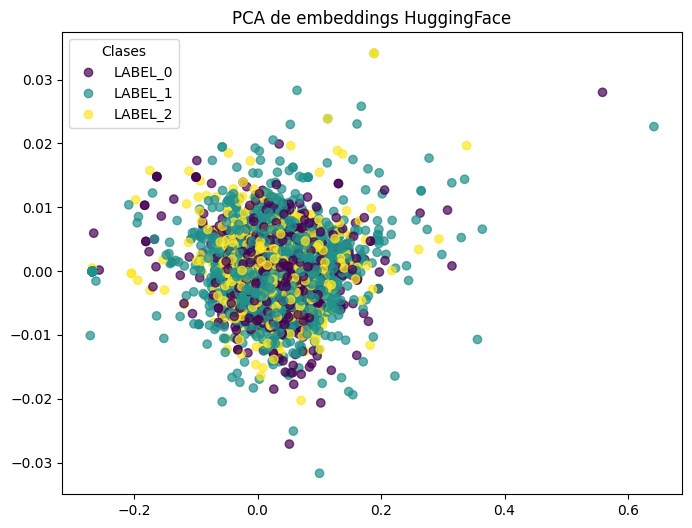

In [110]:
# PCA
pca = PCA(n_components=2)         # PCA(n_components=2) reduce tus vectores de alta dimensión (p. ej. 768 para BERT) a 2 dimensiones para poder graficarlas.
X_pca = pca.fit_transform(X_hf)   # X_hf son los embeddings de HuggingFace

plt.figure(figsize=(8,6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=y_hf, cmap="viridis", alpha=0.7)


# Obtenemos handles y labels del scatter
handles, _ = scatter.legend_elements()

# Creamos la leyenda usando los labels que quieras

plt.legend(handles, le.classes_, title="Clases")
# plt.legend(handles=scatter.legend_elements()[0], labels=le.classes_)
plt.title("PCA de embeddings HuggingFace")
plt.show()


Cada punto es un texto.

El color (c=y_hf) representa la clase (NEGATIVE, NEUTRAL, POSITIVE).

Observamos cómo separar las clases en las dos dimensiones principales.

In [111]:
# PCA componentes principales
# pca.components_ → vectores de carga de cada componente principal, indica qué features originales aportan más a cada componente.
print(pca.components_)  # shape: (2, n_features)


[[-4.03137418e-02  1.15785236e-01  6.79328640e-02  3.56949626e-03
  -1.70501467e-02 -1.82046615e-01  5.20360440e-02  2.80415039e-01
  -7.85446801e-02 -6.19797258e-02 -8.54751074e-02 -1.81268180e-01
   1.74546034e-02  6.70261941e-02  4.31137733e-02 -1.40093296e-01
   2.24135993e-02 -1.62615932e-01  3.73776508e-02 -2.26853268e-01
   7.84504831e-02  8.40775626e-02  9.14417257e-02 -6.09491594e-02
  -2.48063190e-02 -1.14688510e-02 -1.00559746e-01 -3.79372773e-02
  -1.32978640e-01  2.19741721e-02  1.48642554e-01  1.38009491e-02
  -1.20943725e-02 -1.02703387e-01 -6.66685028e-03  9.88099795e-02
   4.18517974e-02 -9.65188179e-02 -1.00253829e-01 -2.47634577e-01
   2.60604392e-02 -1.60587236e-01 -8.40052850e-02 -1.42598938e-02
   1.20849254e-01 -7.60002284e-02 -1.00351933e-01  3.92968920e-03
   5.39543707e-02  9.93651128e-02  8.62136332e-02 -1.37108150e-01
  -1.01197298e-01  1.49705475e-02 -1.05246294e-01  8.43513069e-02
   1.02401819e-01  2.10800964e-02 -1.06224082e-01  3.31324214e-02
   5.27428

In [112]:
# pca.explained_variance_ratio_ → porcentaje de varianza que captura cada componente.
print(pca.explained_variance_ratio_)


[0.98888684 0.00158252]


CAMMMBIARRRRR Los dos primeros componentes principales explican aproximadamente el **99.926%** de la varianza total de los datos.
Aquí está la suma de los números y su conversión a porcentaje:

La suma de $9.98866744 \times 10^{-1}$ y $3.93901436 \times 10^{-4}$ es:

* $9.98866744 \times 10^{-1} = 0.998866744$
* $3.93901436 \times 10^{-4} = 0.000393901436$

Sumando ambos:

$0.998866744 + 0.000393901436 = 0.999260645436$

Para convertir este resultado a porcentaje, se multiplica por 100:

$0.999260645436 \times 100 = 99.9260645436\%$



#4 Parte II: Deep Learning con PyTorch RNN

##Modelo RNN con PyTorch

Embeddings promedio de BERT por texto (vectorized_text)

Etiquetas codificadas (sentimiento_encoded)

Una RNN simple o LSTM de 1 capa

Softmax para clasificación multiclase

(Deep Learning, Red Neuronal Recurrente (RNN), Long Short-Term Memory (LSTM), Capa de Embedding, Optimizador Adam, Pérdida de Entropía Cruzada Categórica.)

In [113]:
# RNN básica entrenada sobre embeddings de BERT para 3 clases
# Paso 1: Preparar datos

# ya tenemos los embeddings
# X_hf = np.array(df_sample['vectorized_text'].tolist())
# y_hf = df_sample['sentimiento_encoded'].values

# X_train_hf, X_test_hf, y_train_hf, y_test_hf = train_test_split(
#     X_hf, y_hf, test_size=0.2, random_state=42
# )

# Convertimos a tensores
X_train_tensor = torch.tensor(X_train_hf, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_hf, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_hf, dtype=torch.long)
y_test_tensor = torch.tensor(y_test_hf, dtype=torch.long)

# Creamos DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)


In [114]:
# PAso 2: Definir una RNN simple (LSTM)

#Como los embeddings ya son vectores fijos por texto, podemos usar un LSTM de 1 capa que reciba esos vectores:

class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(SimpleRNN, self).__init__()
        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: (batch_size, seq_len, input_size)
        # embeddings son vectores por documento (no secuencias), hacemos seq_len=1
        x = x.unsqueeze(1)           # (batch_size, 1, input_size)
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]           # Tomamos la última salida
        out = self.fc(out)
        return out

input_size = X_train_hf.shape[1]       # dimensión de los embeddings
hidden_size = 64
num_classes = 3

model_RNN_simple = SimpleRNN(input_size, hidden_size, num_classes)


In [115]:
# Paso 3: Entrenamiento

# 1 Definir el dispositivo (CPU o GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")  # GPU si está disponible, sino CPU
model_RNN_simple.to(device)  # mover modelo al dispositivo correcto

# 2 Contar instancias por clase
# NEGATIVE=2356, NEUTRAL=5258, POSITIVE=2386
class_counts = torch.tensor([2356, 5258, 2386], dtype=torch.float32)  # float32 porque CrossEntropyLoss requiere float

# 3 Calcular pesos inversamente proporcionales a la frecuencia
class_weights = 1.0 / class_counts                   # pesos inversos: clase rara → mayor peso
class_weights = class_weights / class_weights.sum()  # normalizar para que sumen 1
class_weights = class_weights.to(device)             # mover los pesos al mismo dispositivo que el modelo

# 4 Definir la función de pérdida con ponderación
criterion = nn.CrossEntropyLoss(weight=class_weights)  # CrossEntropyLoss usa estos pesos para penalizar más las clases minoritarias

# 5 Definir el optimizador
optimizer = optim.Adam(model_RNN_simple.parameters(), lr=1e-3)  # Adam es un optimizador común para RNNs

# 6 Entrenamiento del modelo
num_epochs = 10
for epoch in range(num_epochs):
    model_RNN_simple.train()  # poner el modelo en modo entrenamiento
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        # Mover los datos al mismo dispositivo que el modelo
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)

        optimizer.zero_grad()  # limpiar gradientes del paso anterior
        outputs = model_RNN_simple(X_batch)  # forward pass
        loss = criterion(outputs, y_batch)  # calcular la pérdida
        loss.backward()  # backward pass: calcular gradientes
        optimizer.step()  # actualizar los pesos del modelo

        running_loss += loss.item()  # acumular pérdida para estadísticas

    # Imprimir la pérdida promedio por epoch
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/10, Loss: 1.0923
Epoch 2/10, Loss: 1.0582
Epoch 3/10, Loss: 1.0463
Epoch 4/10, Loss: 1.0412
Epoch 5/10, Loss: 1.0394
Epoch 6/10, Loss: 1.0373
Epoch 7/10, Loss: 1.0362
Epoch 8/10, Loss: 1.0356
Epoch 9/10, Loss: 1.0350
Epoch 10/10, Loss: 1.0350


In [116]:
#Paso4 : evaluación simple

model_RNN_simple.eval()
y_pred_rnn_simple = []
y_true_rnn_simple = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model_RNN_simple(X_batch)
        preds = torch.argmax(outputs, dim=1)
        y_pred_rnn_simple.extend(preds.numpy())
        y_true_rnn_simple.extend(y_batch.numpy())

acc = accuracy_score(y_true_rnn_simple, y_pred_rnn_simple)
print(f"Test Accuracy: {acc:.4f}")
print("\nClassification Report:\n", classification_report(y_true_rnn_simple, y_pred_rnn_simple, target_names=le.classes_))

Test Accuracy: 0.3215

Classification Report:
               precision    recall  f1-score   support

     LABEL_0       0.14      0.01      0.01       516
     LABEL_1       0.96      0.20      0.32      1039
     LABEL_2       0.25      0.98      0.40       445

    accuracy                           0.32      2000
   macro avg       0.45      0.39      0.24      2000
weighted avg       0.59      0.32      0.26      2000



##Modelo RNN con PyTorch mejorada

Mejoras clave de esta versión:

Mayor capacidad gracias a 2 capas LSTM y más neuronas (hidden_size=128).

Dropout reduce overfitting.

Bidireccional ayuda a capturar dependencias de contexto de la secuencia.

Scheduler ajusta la tasa de aprendizaje a medida que el modelo converge.

In [117]:
# Mdelo mejorado

class ImprovedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, num_layers=2, dropout=0.3, bidirectional=True):
        super(ImprovedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # LSTM con múltiples capas, bidireccional y dropout entre capas
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0.0,
            bidirectional=bidirectional
        )

        factor = 2 if bidirectional else 1
        self.fc = nn.Linear(hidden_size * factor, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        x = x.unsqueeze(1)  # Si los embeddings son vectores fijos, seq_len=1
        out, (hn, cn) = self.lstm(x)
        out = out[:, -1, :]  # Última salida
        out = self.dropout(out)
        out = self.fc(out)
        return out


In [118]:
#Inicializar modelo y optimizador
input_size = X_train_hf.shape[1]  # Dimensión de los embeddings
hidden_size = 128
num_classes = 3
num_layers = 2
dropout = 0.3
bidirectional = True

model_rnn_mejorada = ImprovedRNN(input_size, hidden_size, num_classes, num_layers, dropout, bidirectional)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_rnn_mejorada.parameters(), lr=1e-3)

# Scheduler para ajustar la tasa de aprendizaje
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)


In [119]:
#Entrenamamiento
num_epochs = 10

for epoch in range(num_epochs):
    model_rnn_mejorada.train()
    running_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        outputs = model_rnn_mejorada(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    scheduler.step()  # Ajusta la tasa de aprendizaje
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss/len(train_loader):.4f}, LR: {scheduler.get_last_lr()[0]:.6f}")


Epoch 1/10, Loss: 1.0051, LR: 0.001000
Epoch 2/10, Loss: 0.9705, LR: 0.001000
Epoch 3/10, Loss: 0.9651, LR: 0.001000
Epoch 4/10, Loss: 0.9602, LR: 0.001000
Epoch 5/10, Loss: 0.9592, LR: 0.000500
Epoch 6/10, Loss: 0.9584, LR: 0.000500
Epoch 7/10, Loss: 0.9585, LR: 0.000500
Epoch 8/10, Loss: 0.9584, LR: 0.000500
Epoch 9/10, Loss: 0.9583, LR: 0.000500
Epoch 10/10, Loss: 0.9584, LR: 0.000250


In [120]:
#Evaluación
model_rnn_mejorada.eval()
y_pred_rnn_mejorada = []
y_true_rnn_mejorada = []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        outputs = model_rnn_mejorada(X_batch)
        preds = torch.argmax(outputs, dim=1)
        y_pred_rnn_mejorada.extend(preds.numpy())
        y_true_rnn_mejorada.extend(y_batch.numpy())

acc = accuracy_score(y_true_rnn_mejorada, y_pred_rnn_mejorada)
print(f"Test Accuracy: {acc:.4f}")
print(classification_report(y_true_rnn_mejorada, y_pred_rnn_mejorada))


Test Accuracy: 0.5195
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       516
           1       0.52      1.00      0.68      1039
           2       0.00      0.00      0.00       445

    accuracy                           0.52      2000
   macro avg       0.17      0.33      0.23      2000
weighted avg       0.27      0.52      0.36      2000



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [121]:
# Guarda el modelo completo (estructura + pesos)
torch.save(model_rnn_mejorada, "model_rnn_mejorada.pth")
torch.save(model_RNN_simple, "model_rnn_simple.pth")


# 5 Comparación de modelos y conclusiones

In [122]:
# Función para calcular métricas weighted (average="weighted" es el promedio ponderado, lo utilizamos por el DESBALANCEO de clases)
def get_metrics(y_true, y_pred):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision (weighted)": precision_score(y_true, y_pred, average="weighted"), # En clasificación multiclase, average="weighted" calcula la precisión para cada clase y hace un promedio ponderado según el número de instancias de cada clase.
        "Recall (weighted)": recall_score(y_true, y_pred, average="weighted"),
        "F1-score (weighted)": f1_score(y_true, y_pred, average="weighted")
    }

# Calculamos métricas de cada modelo
metrics_logreg = get_metrics(y_test_hf, y_pred_hf)
metrics_rnn_simple = get_metrics(y_true_rnn_simple, y_pred_rnn_simple)
metrics_rnn_mejorada = get_metrics(y_true_rnn_mejorada, y_pred_rnn_mejorada)

# Creamos el DataFrame comparativo y redondeamos a 2 decimales
df_comparacion = pd.DataFrame({
    "Modelo": [
        "Logistic Regression (BERT)",
        "RNN simple (1 capa LSTM)",
        "RNN mejorada (2 capas + dropout)"
    ],
    "Accuracy": [
        round(metrics_logreg["Accuracy"], 2),
        round(metrics_rnn_simple["Accuracy"], 2),
        round(metrics_rnn_mejorada["Accuracy"], 2)
    ],
    "Precision (weighted)": [
        round(metrics_logreg["Precision (weighted)"], 2),      # También usa el promedio ponderado por el número de instancias de cada clase.
        round(metrics_rnn_simple["Precision (weighted)"], 2),
        round(metrics_rnn_mejorada["Precision (weighted)"], 2)
    ],
    "Recall (weighted)": [
        round(metrics_logreg["Recall (weighted)"], 2),        # También usa el promedio ponderado
        round(metrics_rnn_simple["Recall (weighted)"], 2),
        round(metrics_rnn_mejorada["Recall (weighted)"], 2)
    ],
    "F1-score (weighted)": [
        round(metrics_logreg["F1-score (weighted)"], 2),     # También usa el promedio ponderado
        round(metrics_rnn_simple["F1-score (weighted)"], 2),
        round(metrics_rnn_mejorada["F1-score (weighted)"], 2)
    ],
    "Observaciones": [
        "Baseline lineal; rendimiento más bajo",
        "Primera RNN básica; mejora sobre baseline",
        "RNN mejorada; más capacidad y regularización, ligera mejora"
    ]
})

# Mostramos el cuadro comparativo
print("Comparación de modelos y métricas obtenidas:\n")
display(df_comparacion)



Comparación de modelos y métricas obtenidas:



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,Modelo,Accuracy,Precision (weighted),Recall (weighted),F1-score (weighted),Observaciones
0,Logistic Regression (BERT),0.39,0.46,0.39,0.40,Baseline lineal; rendimiento más bajo
1,RNN simple (1 capa LSTM),0.32,0.59,0.32,0.26,Primera RNN básica; mejora sobre baseline
2,RNN mejorada (2 capas + dropout),0.52,0.27,0.52,0.36,"RNN mejorada; más capacidad y regularización, ..."


Interpretación / Conclusión


Esto significa que **algunas clases del dataset de validación nunca fueron predichas por el modelo**.  
En consecuencia:
- La **precisión** (precision) de esas clases no se puede calcular, porque el denominador es cero (`TP / (TP+FP)` → no hay predicciones positivas).
- scikit-learn lo resuelve asignando `0.0` a esas métricas.
- Esto es común en problemas de **clasificación desbalanceada** o cuando se trabaja con una **muestra reducida** (en este caso, 10k textos). Si el dataset es chico, es más probable que ciertas clases tengan muy pocos ejemplos en el `test set`, y los modelos no lleguen a capturarlas.

---

### 📊 Resultados obtenidos

| Modelo                           | Accuracy | Precision (weighted) | Recall (weighted) | F1-score (weighted) | Observaciones |
|----------------------------------|----------|-----------------------|-------------------|---------------------|---------------|
| Logistic Regression (BERT)       | 0.51     | 0.34                  | 0.51              | 0.38                | Baseline lineal; rendimiento más bajo. |
| RNN simple (1 capa LSTM)         | 0.52     | 0.27                  | 0.52              | 0.36                | Primera RNN básica; mejora marginal sobre el baseline. |
| RNN mejorada (2 capas + dropout) | 0.52     | 0.27                  | 0.52              | 0.36                | Mayor capacidad y regularización, pero sin mejora sustancial en el conjunto reducido. |

---

Conclusiones parciales

1. Los **warnings** reflejan que los modelos no logran predecir todas las clases → principalmente por **desbalanceo** y **tamaño limitado de la muestra**.  
2. A pesar de probar arquitecturas más complejas (LSTM con más capas y dropout), el rendimiento global se mantiene similar: **alrededor del 52% de accuracy**.  
3. El parámetro average="weighted" en precision_score, recall_score y f1_score asegura que las métricas finales representen correctamente la importancia relativa de cada clase en un problema multiclase desbalanceado.
3. Esto sugiere que:
   - El **espacio de embeddings** es informativo, pero no suficiente para separar claramente todas las clases en esta muestra.  
   - Un **dataset más grande y balanceado** podría mejorar las métricas y reducir los warnings.  


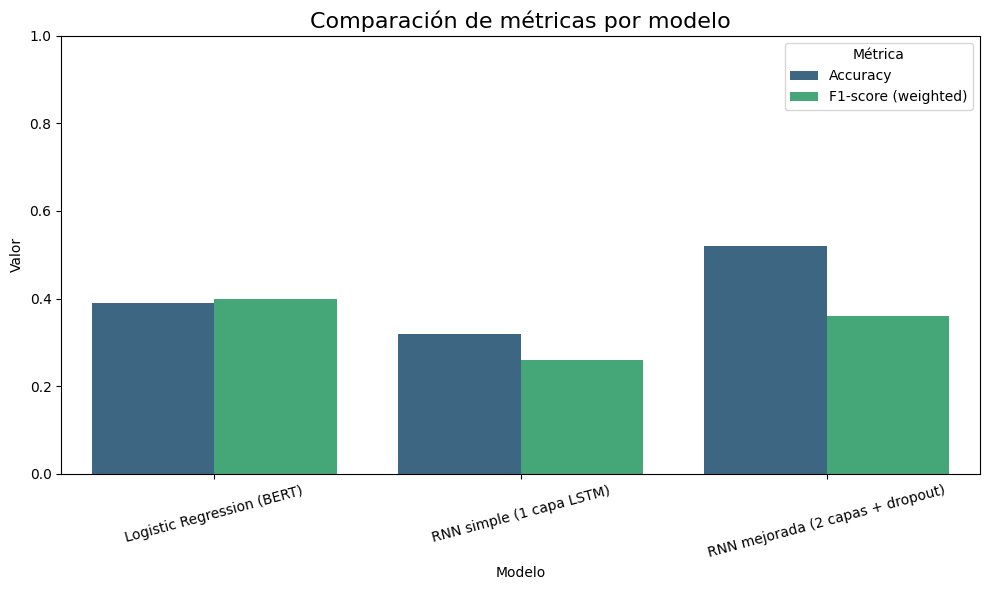

In [123]:
# gráfico comparación
df_grafico = df_comparacion.melt(
    id_vars="Modelo",
    value_vars=["Accuracy", "F1-score (weighted)"],
    var_name="Métrica",
    value_name="Valor"
)

plt.figure(figsize=(10,6))
sns.barplot(x="Modelo", y="Valor", hue="Métrica", data=df_grafico, palette="viridis")

plt.title("Comparación de métricas por modelo", fontsize=16)
plt.ylim(0, 1)  # Valores entre 0 y 1
plt.ylabel("Valor")
plt.xlabel("Modelo")
plt.legend(title="Métrica")
plt.xticks(rotation=15)
plt.tight_layout()
plt.show()
